# ChestXRay CLIP Embeddings and PCA Visualization

This notebook downloads the ChestXRay2017 dataset, generates CLIP embeddings for all images, and visualizes them in a 2D PCA space.

## Install Required Packages

In [ ]:
!pip install torch torchvision matplotlib numpy scikit-learn tqdm pillow
!pip install git+https://github.com/openai/CLIP.git
!pip install gdown

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## Download and Extract Dataset

In [ ]:
!if [ ! -f ChestXRay2017.zip ]; then gdown --fuzzy https://drive.google.com/file/d/1jf1XvAeXPD4XAerknz5inxM0StuCNbyX/view?usp=sharing; unzip ChestXRay2017.zip; fi

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/PNEUMONIA/person1562_bacteria_4078.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/P

## Import Required Libraries

In [ ]:
import os
import torch
import clip
import numpy as np
from torchvision import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## Set Up Device and Load CLIP Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model, preprocess = clip.load("ViT-B/32", device=device)

Using device: cuda


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 65.4MiB/s]


## Define Custom Dataset and Load Images

In [ ]:
data_dir = 'chest_xray'

class CustomImageDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        return path, target

image_datasets = {x: CustomImageDataset(os.path.join(data_dir, x))
                  for x in ['train', 'test']}

all_images = image_datasets['train'].samples + image_datasets['test'].samples

## Generate CLIP Embeddings

In [ ]:
def generate_embeddings(image_paths, model, preprocess):
    all_embeddings = []
    all_labels = []
    all_filenames = []

    model.eval()
    with torch.no_grad():
        for path, label in tqdm(image_paths, desc="Generating embeddings"):
            image = preprocess(Image.open(path)).unsqueeze(0).to(device)
            embedding = model.encode_image(image)

            all_embeddings.append(embedding.cpu().numpy())
            all_labels.append(label)
            all_filenames.append(os.path.relpath(path, data_dir))

    return np.vstack(all_embeddings), np.array(all_labels), np.array(all_filenames)

print("Generating CLIP embeddings...")
embeddings, labels, filenames = generate_embeddings(all_images, model, preprocess)

Generating CLIP embeddings...


Generating embeddings: 100%|██████████| 5856/5856 [02:02<00:00, 47.74it/s]


## Perform PCA and Visualize

Performing PCA...


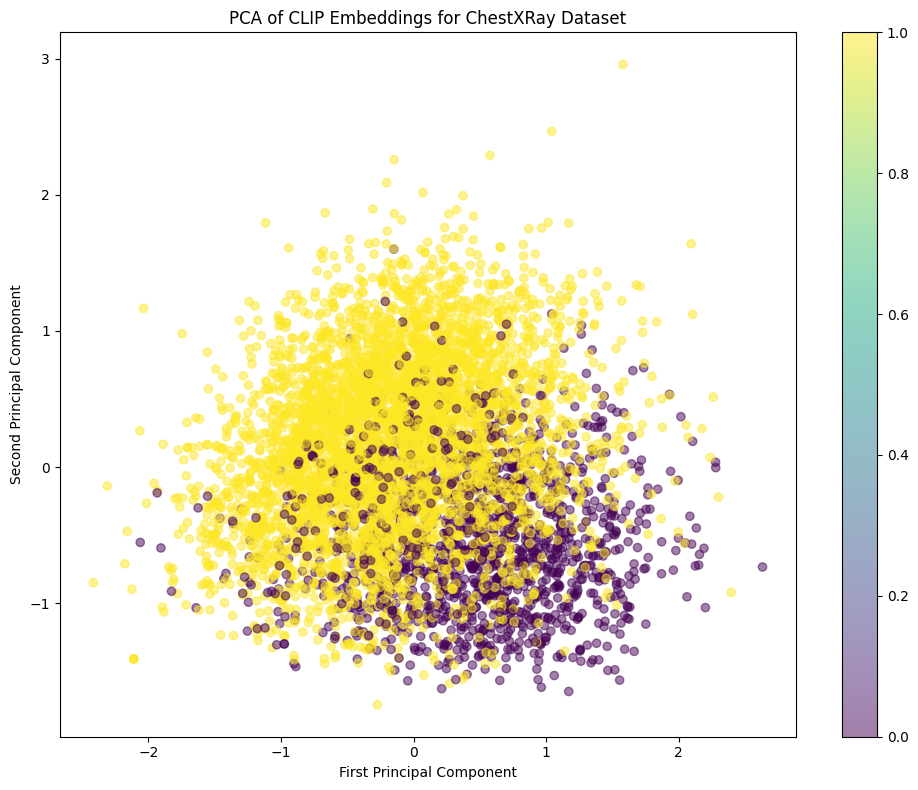

PCA visualization saved as 'chest_xray_clip_pca_visualization.png'
Total number of images: 5856
Number of classes: 2
Embedding dimension: 512


In [ ]:
print("Performing PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('PCA of CLIP Embeddings for ChestXRay Dataset')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

num_thumbnails = 10
indices = np.random.choice(len(embeddings), num_thumbnails, replace=False)

for idx in indices:
    x, y = embeddings_2d[idx]

plt.tight_layout()
plt.show()

print("PCA visualization saved as 'chest_xray_clip_pca_visualization.png'")

print(f"Total number of images: {len(embeddings)}")
print(f"Number of classes: {len(np.unique(labels))}")
print(f"Embedding dimension: {embeddings.shape[1]}")

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming 'embeddings' and 'labels' are already defined from the previous code

# Perform 3D PCA
print("Performing 3D PCA...")
pca_3d = PCA(n_components=3)
embeddings_3d = pca_3d.fit_transform(embeddings)

# Create a color map
unique_labels = np.unique(labels)
color_map = {label: f'rgb({np.random.randint(0,255)},{np.random.randint(0,255)},{np.random.randint(0,255)})'
             for label in unique_labels}

# Create the 3D scatter plot
trace = go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_map[label] for label in labels],
        opacity=0.8
    ),
    text=[f"Label: {label}" for label in labels],
    hoverinfo='text'
)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis_title="First Principal Component",
        yaxis_title="Second Principal Component",
        zaxis_title="Third Principal Component",
    ),
    title="Interactive 3D PCA of CLIP Embeddings for ChestXRay Dataset"
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

# Save the interactive plot as an HTML file
fig.write_html("interactive_3d_pca_plot.html")
print("Interactive 3D PCA visualization saved as 'interactive_3d_pca_plot.html'")

# Print explained variance ratio
explained_variance_ratio = pca_3d.explained_variance_ratio_
print("Explained variance ratio:")
print(f"PC1: {explained_variance_ratio[0]:.4f}")
print(f"PC2: {explained_variance_ratio[1]:.4f}")
print(f"PC3: {explained_variance_ratio[2]:.4f}")
print(f"Total: {sum(explained_variance_ratio):.4f}")

Performing 3D PCA...


Interactive 3D PCA visualization saved as 'interactive_3d_pca_plot.html'
Explained variance ratio:
PC1: 0.1388
PC2: 0.1200
PC3: 0.0934
Total: 0.3523


Original dimensionality of CLIP embeddings: 512
Number of components needed for 95% of variance: 111

Explained Variance Ratio:
2D PCA: 0.2589
3D PCA: 0.3523

Individual Component Contributions:
1st Principal Component: 0.1388
2nd Principal Component: 0.1200
3rd Principal Component: 0.0934


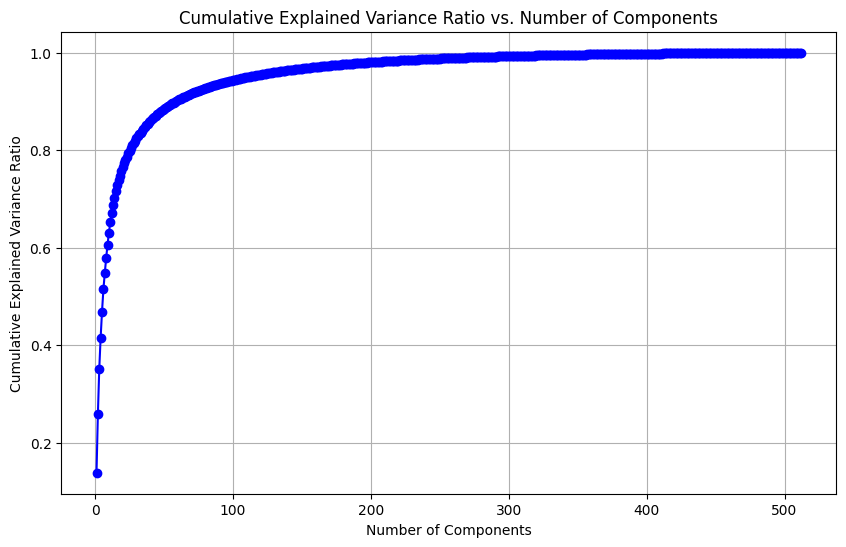


Cumulative variance plot saved as 'cumulative_variance_plot.png'


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'embeddings' is already defined from the previous code

# Perform PCA
pca = PCA()
pca.fit(embeddings)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Print dimensionality information
print(f"Original dimensionality of CLIP embeddings: {embeddings.shape[1]}")

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed for 95% of variance: {n_components_95}")

# Print explained variance for 2D and 3D PCA
print("\nExplained Variance Ratio:")
print(f"2D PCA: {pca.explained_variance_ratio_[:2].sum():.4f}")
print(f"3D PCA: {pca.explained_variance_ratio_[:3].sum():.4f}")

# Print individual component contributions
print("\nIndividual Component Contributions:")
print(f"1st Principal Component: {pca.explained_variance_ratio_[0]:.4f}")
print(f"2nd Principal Component: {pca.explained_variance_ratio_[1]:.4f}")
print(f"3rd Principal Component: {pca.explained_variance_ratio_[2]:.4f}")

# Plotting the cumulative explained variance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.savefig('cumulative_variance_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCumulative variance plot saved as 'cumulative_variance_plot.png'")

Computing KMeans: 100%|██████████| 29/29 [01:36<00:00,  3.34s/it]


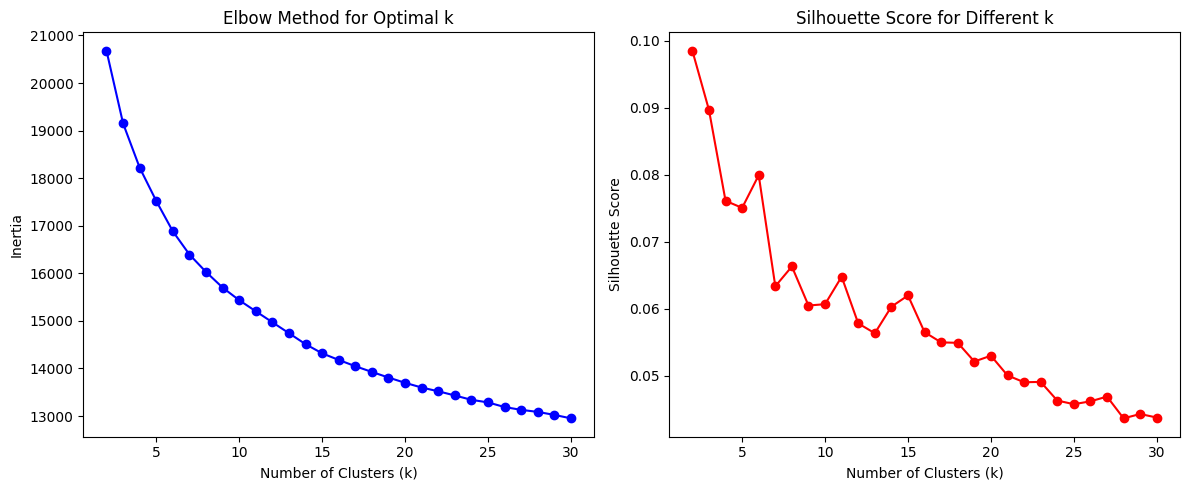

KMeans elbow plot saved as 'kmeans_elbow_plot.png'
Optimal number of clusters based on the elbow method: 28
Number of clusters with highest silhouette score: 2

Cluster distribution for k=28:
Cluster 0: 233 samples
Cluster 1: 273 samples
Cluster 2: 166 samples
Cluster 3: 247 samples
Cluster 4: 191 samples
Cluster 5: 246 samples
Cluster 6: 258 samples
Cluster 7: 191 samples
Cluster 8: 288 samples
Cluster 9: 370 samples
Cluster 10: 92 samples
Cluster 11: 249 samples
Cluster 12: 277 samples
Cluster 13: 300 samples
Cluster 14: 268 samples
Cluster 15: 150 samples
Cluster 16: 145 samples
Cluster 17: 15 samples
Cluster 18: 201 samples
Cluster 19: 241 samples
Cluster 20: 192 samples
Cluster 21: 228 samples
Cluster 22: 167 samples
Cluster 23: 269 samples
Cluster 24: 281 samples
Cluster 25: 60 samples
Cluster 26: 129 samples
Cluster 27: 129 samples

Silhouette score for optimal clustering: 0.0436


In [13]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'embeddings' is already defined from the previous code

# Function to compute KMeans for a range of k values
def compute_kmeans(data, max_k):
    inertias = []
    silhouette_scores = []
    k_values = range(2, max_k + 1)

    for k in tqdm(k_values, desc="Computing KMeans"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    return k_values, inertias, silhouette_scores

# Compute KMeans for k=2 to k=20
max_k = 30
k_values, inertias, silhouette_scores = compute_kmeans(embeddings, max_k)

# Plot the elbow curve
plt.figure(figsize=(12, 5))

# Inertia plot
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')

plt.tight_layout()
plt.savefig('kmeans_elbow_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("KMeans elbow plot saved as 'kmeans_elbow_plot.png'")

# Find the optimal k using the elbow method
def find_elbow(inertias):
    diffs = np.diff(inertias)
    elbow_index = np.argmax(diffs) + 1  # +1 because diff reduces array size by 1
    return k_values[elbow_index]

optimal_k = find_elbow(inertias)
print(f"Optimal number of clusters based on the elbow method: {optimal_k}")

# Find the k with the highest silhouette score
best_silhouette_k = k_values[np.argmax(silhouette_scores)]
print(f"Number of clusters with highest silhouette score: {best_silhouette_k}")

# Perform KMeans with the optimal k
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = optimal_kmeans.fit_predict(embeddings)

print(f"\nCluster distribution for k={optimal_k}:")
for i in range(optimal_k):
    print(f"Cluster {i}: {np.sum(cluster_labels == i)} samples")

# Calculate silhouette score for the optimal clustering
optimal_silhouette = silhouette_score(embeddings, cluster_labels)
print(f"\nSilhouette score for optimal clustering: {optimal_silhouette:.4f}")

In [15]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming 'embeddings', 'optimal_k', and 'labels' are already defined from the previous code

# Perform 3D PCA
pca_3d = PCA(n_components=3)
embeddings_3d = pca_3d.fit_transform(embeddings)

# Perform KMeans clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Create a color map for clusters
colors = [f'rgb({np.random.randint(0,255)},{np.random.randint(0,255)},{np.random.randint(0,255)})'
          for _ in range(optimal_k)]

# Create traces for each cluster
traces = []
for i in range(optimal_k):
    cluster_points = embeddings_3d[cluster_labels == i]
    trace = go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=colors[i],
            opacity=0.8
        ),
        name=f'Cluster {i}',
        text=[f"Cluster: {i}, True Label: {labels[j]}" for j in np.where(cluster_labels == i)[0]],
        hoverinfo='text'
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis_title="First Principal Component",
        yaxis_title="Second Principal Component",
        zaxis_title="Third Principal Component",
    ),
    title=f"Interactive 3D PCA of CLIP Embeddings with {optimal_k} KMeans Clusters",
    legend_title="Clusters"
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

# Save the interactive plot as an HTML file
fig.write_html("interactive_3d_pca_kmeans_plot.html")
print(f"Interactive 3D PCA visualization with {optimal_k} KMeans clusters saved as 'interactive_3d_pca_kmeans_plot.html'")

# Print explained variance ratio
explained_variance_ratio = pca_3d.explained_variance_ratio_
print("Explained variance ratio:")
print(f"PC1: {explained_variance_ratio[0]:.4f}")
print(f"PC2: {explained_variance_ratio[1]:.4f}")
print(f"PC3: {explained_variance_ratio[2]:.4f}")
print(f"Total: {sum(explained_variance_ratio):.4f}")

# Calculate and print cluster sizes
cluster_sizes = np.bincount(cluster_labels)
print("\nCluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i}: {size} samples")

# Calculate the proportion of each true label in each cluster
true_labels = np.array(labels)
for i in range(optimal_k):
    cluster_mask = cluster_labels == i
    cluster_true_labels = true_labels[cluster_mask]
    unique, counts = np.unique(cluster_true_labels, return_counts=True)
    proportions = counts / len(cluster_true_labels)

    print(f"\nCluster {i} composition:")
    for label, prop in zip(unique, proportions):
        print(f"  {label}: {prop:.2%}")

Interactive 3D PCA visualization with 28 KMeans clusters saved as 'interactive_3d_pca_kmeans_plot.html'
Explained variance ratio:
PC1: 0.1388
PC2: 0.1200
PC3: 0.0934
Total: 0.3523

Cluster sizes:
Cluster 0: 233 samples
Cluster 1: 273 samples
Cluster 2: 166 samples
Cluster 3: 247 samples
Cluster 4: 191 samples
Cluster 5: 246 samples
Cluster 6: 258 samples
Cluster 7: 191 samples
Cluster 8: 288 samples
Cluster 9: 370 samples
Cluster 10: 92 samples
Cluster 11: 249 samples
Cluster 12: 277 samples
Cluster 13: 300 samples
Cluster 14: 268 samples
Cluster 15: 150 samples
Cluster 16: 145 samples
Cluster 17: 15 samples
Cluster 18: 201 samples
Cluster 19: 241 samples
Cluster 20: 192 samples
Cluster 21: 228 samples
Cluster 22: 167 samples
Cluster 23: 269 samples
Cluster 24: 281 samples
Cluster 25: 60 samples
Cluster 26: 129 samples
Cluster 27: 129 samples

Cluster 0 composition:
  0: 0.86%
  1: 99.14%

Cluster 1 composition:
  0: 2.56%
  1: 97.44%

Cluster 2 composition:
  0: 85.54%
  1: 14.46%

Cl